# GAN Clean to Dammaged

Le but de ce GAN est de transformer des pommes en bon état en pommes endommagées 

## Installations requises :

In [ ]:
! pip install tensorflow 
! pip install -q git+https://github.com/tensorflow/examples.git # installation de tensorflow_examples pour avoir accès au modèle pix2pix

## Importations :

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

Création des training datas

In [ ]:
image_size = (256, 256)
batch_size = 16 

#Train 
train_clean_apples = tf.keras.preprocessing.image_dataset_from_directory(
    "/Clean_apple/", #Dossier contenant les images des pommes en bon état
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode='rgb',
    image_size=image_size,
    batch_size=batch_size,
    label_mode= None)

train_dammaged_apples = tf.keras.preprocessing.image_dataset_from_directory(
    "/Dammaged_apple", #Dossier contenant les images des pommes endommagés
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode='rgb',
    image_size=image_size,
    batch_size=batch_size,
    label_mode= None)

#Test 
test_clean_apples = tf.keras.preprocessing.image_dataset_from_directory(
    "/Clean_apple/", #Dossier contenant les images des pommes en bon état
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode='rgb',
    image_size=image_size,
    batch_size=batch_size,
    label_mode= None)

test_dammaged_apples = tf.keras.preprocessing.image_dataset_from_directory(
    "/Dammaged_apple", #Dossier contenant les images des pommes endommagés
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode='rgb',
    image_size=image_size,
    batch_size=batch_size,
    label_mode= None)


## Normalisation des images

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
# normalise les images en [-1, 1]
def normalize(image,):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def preprocess_image_train(image):
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

In [ ]:
train_clean_apples = train_clean_apples.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

train_dammaged_apples = train_dammaged_apples.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

test_clean_apples = test_clean_apples.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

test_dammaged_apples = test_dammaged_apples.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE)

## Visualistaion

In [ ]:
sample_clean_apples = next(iter(train_clean_apples))
sample_dammaged_apples = next(iter(train_dammaged_apples))

In [ ]:
plt.subplot(121)
plt.title('Clean Apple')
plt.imshow(sample_clean_apples[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Dammaged Apple')
plt.imshow(sample_dammaged_apples[0] * 0.5 + 0.5)

## Importation du Modèle

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Visualisation du modèle non entraîné :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


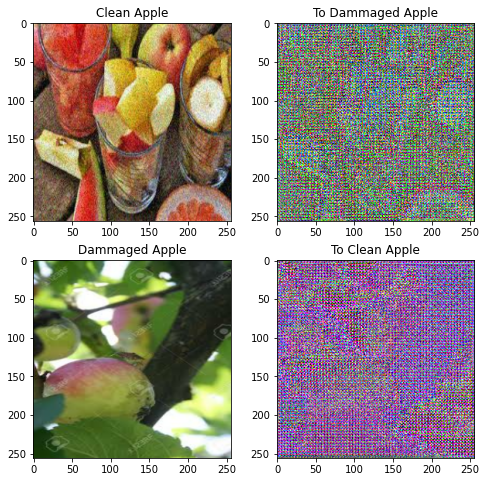

In [ ]:
to_dammaged = generator_g(sample_clean_apples)
to_clean = generator_f(sample_dammaged_apples)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_clean_apples, to_dammaged, sample_dammaged_apples, to_clean]
title = ['Clean Apple', 'To Dammaged Apple', 'Dammaged Apple', 'To Clean Apple']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

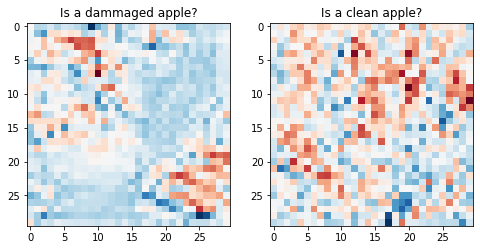

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a dammaged apple?')
plt.imshow(discriminator_y(sample_dammaged_apples)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a clean apple?')
plt.imshow(discriminator_x(sample_clean_apples)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Définition de la fonction de perte (loss)

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
#Optimizeurs
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Définition des checkpoints 

In [ ]:
checkpoint_path = "/checkpoints/ckps"  # chemin d'accès au dossier où seront sauvegardés les checkpoints

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# si un checkpoint existe déjà, restorer le dernier checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

In [ ]:
EPOCHS = 100

In [ ]:
def generate_images(model, test_input,epoch=None):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.title(title[i])
    # avoir les valeurs de pixel entre [0, 1] 
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
    if epoch != None :
      plt.savefig('/Training_images/image_{:04d}.png'.format(epoch)) #enregistre les images générés dans le dossier "Training_images"
    plt.show()

In [ ]:
# fonction d'entraînement
@tf.function
def train_step(real_x, real_y):

  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x et same_y seront utiliser pour l'identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculer la perte : loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculer les gradients pour les generateur et discriminateur
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Appliquer les gradients à l' optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


In [ ]:
# entraînement
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_clean_apples, train_dammaged_apples)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Utiliser une image cohérente (sample_clean_apples) afin que la progression du modèle soit clairement visible.
  generate_images(generator_g, sample_clean_apples, epoch+240)

  if (epoch + 1) % 5 == 0:
    tf.saved_model.save(obj, export_dir, signatures=None, options=None)
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))